## data ingestion and cleaning

In [1]:
%pwd

'd:\\coding\\MLProject\\KindneyDiseaseClassification\\research'

In [2]:
import os

In [3]:
os.chdir("../")
%pwd

'd:\\coding\\MLProject\\KindneyDiseaseClassification'

In [5]:
import random
import shutil
import glob

ctscan_dataset_url= "artifacts/data_ingestion/content/data/CT KIDNEY DATASET Normal, CYST, TUMOR and STONE"

# Create a new directory to save the random images
output_dir = "artifacts/data_ingestion/binary_classification/ct_scan_dataset"
os.makedirs(output_dir, exist_ok=True)

# Get list of all image files from the dataset
image_files = glob.glob(os.path.join(ctscan_dataset_url, "*/*"))

# Pick random images
random_images = random.sample(image_files, 500)

# Copy random images to the new directory
for image in random_images:
  shutil.copy(image, output_dir)

# Get the count of images copied
image_count = len(random_images)
print(f"Number of images copied: {image_count}")

Number of images copied: 500


In [24]:
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# Create a new directory to save the random images from the internet
internet_images_dir = "artifacts/data_ingestion/binary_classification/non_ct_scan_dataset"
os.makedirs(internet_images_dir, exist_ok=True)


image_len= [200,300,400,800,1000,2000,4000,5000]
image_filter = ["?grayscale", "?blur",""]


# Download and save random images
for i in tqdm(range(500), desc="Downloading images"):
  wid_len = random.choice(image_len)
  hei_len = random.choice(image_len)
  img_filter = random.choice(image_filter)
  url = f"https://picsum.photos/{wid_len}/{hei_len}{img_filter}"
  
  response = requests.get(url)
  try:  
    img = Image.open(BytesIO(response.content))
    img.save(os.path.join(internet_images_dir, f"image_{i}.jpg"))
  except Exception as e:
    print(f"Error downloading image from {url}: {e}")

# Get the count of images downloaded
downloaded_image_count = len(os.listdir(internet_images_dir))
print(f"Number of images downloaded: {downloaded_image_count}")


Error downloading image from https://picsum.photos/400/1000?blur: cannot identify image file <_io.BytesIO object at 0x000001A9D680EA70>


Error downloading image from https://picsum.photos/400/2000: cannot identify image file <_io.BytesIO object at 0x000001A9D705F6F0>


Error downloading image from https://picsum.photos/300/1000?grayscale: cannot identify image file <_io.BytesIO object at 0x000001A9D705F6F0>


Error downloading image from https://picsum.photos/4000/200?grayscale: cannot identify image file <_io.BytesIO object at 0x000001A9D65A3CE0>


Error downloading image from https://picsum.photos/300/2000?blur: cannot identify image file <_io.BytesIO object at 0x000001A9D6D05B20>


Error downloading image from https://picsum.photos/200/2000: cannot identify image file <_io.BytesIO object at 0x000001A9D6D05B20>


Number of images downloaded: 494


## Spliting the data into train and test set. The train set will be used to train the model and the test set will be used to evaluate the model.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
ct_scan_dir = "artifacts/data_ingestion/binary_classification/ct_scan_dataset"
non_ct_scan_dir = "artifacts/data_ingestion/binary_classification/non_ct_scan_dataset"

In [32]:
# Get the count of images in each directory
ct_scan_count = len(os.listdir(ct_scan_dir))
non_ct_scan_count = len(os.listdir(non_ct_scan_dir))

# Create a DataFrame
data = {
    "Category": ["CT Scan", "Non CT Scan"],
    "Count": [ct_scan_count, non_ct_scan_count]
}
data_df = pd.DataFrame(data)
data_df

,Category,Count
0,CT Scan,500
1,Non CT Scan,494


In [33]:
# function to load and preprocess image
def load_images_from_dir(directory, label, target_size=(224,224)):
  images = []
  labels = []
  for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename) 
    img = Image.open(img_path).convert('RGB')
    img= img.resize(target_size)
    img_array = np.array(img) / 255.0
    images.append(img_array)
    labels.append(label)
  return images, labels


In [36]:
ct_scan_images, ct_scan_labels = load_images_from_dir(ct_scan_dir , label=1)
non_ct_scan_images, non_ct_scan_labels = load_images_from_dir(non_ct_scan_dir, label=0)

In [37]:
imges = np.array(ct_scan_images + non_ct_scan_images)
labels = np.array(ct_scan_labels + non_ct_scan_labels)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(imges, labels, test_size=0.3, random_state=42)

In [53]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

## Prepare the base model & Train the model

In [57]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))),
model.add(MaxPooling2D((2, 2))),
model.add(Conv2D(64, (3, 3), activation='relu')),
model.add(MaxPooling2D((2, 2))),
model.add(Conv2D(128, (3, 3), activation='relu')),
model.add(MaxPooling2D((2, 2))),
model.add(Flatten()),
model.add(Dense(128, activation='relu')),
model.add(Dropout(0.5)),
model.add(Dense(1, activation='sigmoid'))

c:\Users\Sahil\miniconda3\envs\kidney_CNN_1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [61]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - accuracy: 0.4884 - loss: 0.6933 - val_accuracy: 0.9296 - val_loss: 0.6424
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 388ms/step - accuracy: 0.4881 - loss: 0.6933 - val_accuracy: 0.9296 - val_loss: 0.6424
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.5084 - loss: 0.6930 - val_accuracy: 0.9296 - val_loss: 0.6423
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.5138 - loss: 0.6931 - val_accuracy: 0.9196 - val_loss: 0.6423
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.5063 - loss: 0.6932 - val_accuracy: 0.9246 - val_loss: 0.6424
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.4888 - loss: 0.6934 - val_accuracy: 0.9296 - val_loss: 0.6425
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.9196 - val_loss: 0.6426
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.4796 - loss: 0.6936 - val_accu

In [72]:
%pwd

'd:\\coding\\MLProject\\KindneyDiseaseClassification'

In [73]:
model.save('model/ct_scan_classification_model.h5')


## Model evaluation

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9424 - loss: 0.6426
Validation Accuracy: 92.96%


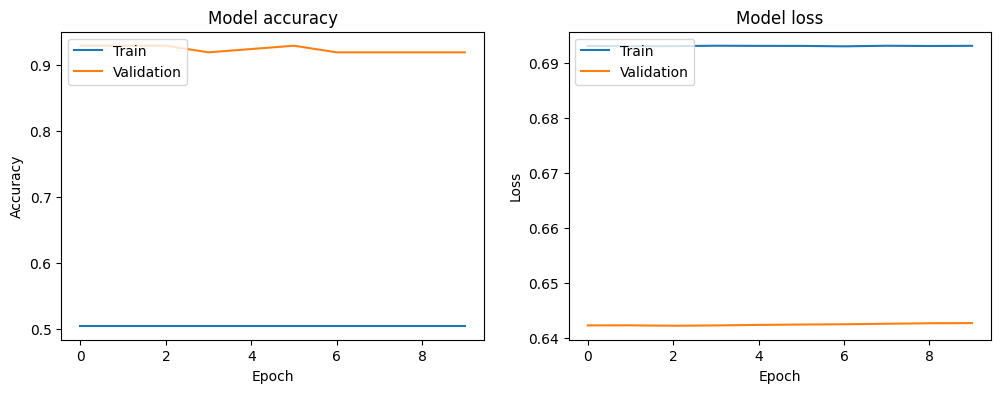

In [62]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


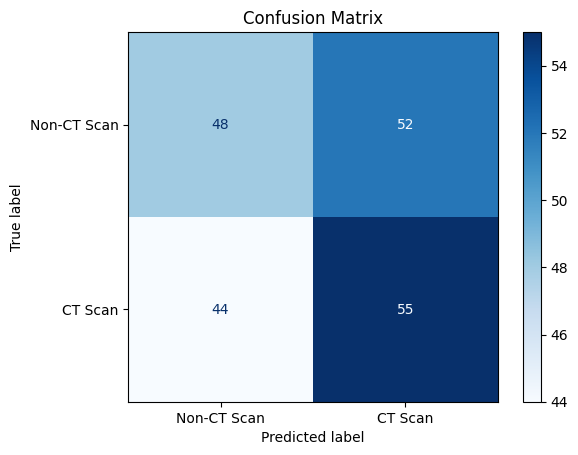

In [67]:
# Make predictions on the test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-CT Scan', 'CT Scan'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Predict With A New Data

In [89]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [74]:
path_model = 'model/ct_scan_classification_model.h5'

In [76]:
classification_model = load_model(path_model)

In [85]:
# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
    return img_array

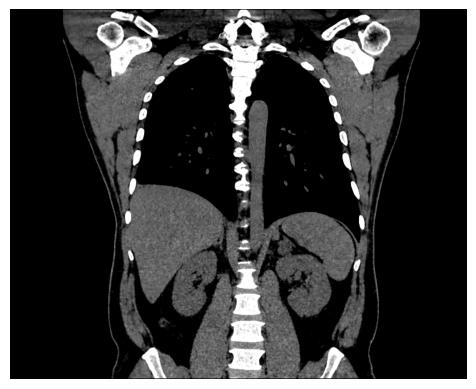

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction Probability: 0.5711
The image is a CT scan of a kidney.


In [104]:
# Path to the new image

# new_image_path = 'artifacts/data_ingestion/binary_classification/ct_scan_dataset/STONE/Stone- (84).jpg'
new_image_path = "artifacts/data_ingestion/content/data/CT KIDNEY DATASET Normal, CYST, TUMOR and STONE/CYST/Cyst- (326).jpg"
# new_image_path = 'artifacts/data_ingestion/binary_classification/non_ct_scan_dataset/image_43.jpg'

# Load and display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

# Preprocess the new image
preprocessed_image = preprocess_image(new_image_path)

# Make predictions
prediction_prob = model.predict(preprocessed_image)
print(f"Prediction Probability: {prediction_prob[0][0]:.4f}")
prediction = (prediction_prob > 0.5).astype(int).flatten()

# Interpret the prediction
if prediction[0] == 1:
    print("The image is a CT scan of a kidney.")
else:
    print("\033[1mThe image is not a CT scan of a kidney.\033[0m")